# Data simulation

Using the Dynamic Generalised Models library https://github.com/ruivieira/python-ssm

In [1]:
from pssm.dglm import NormalDLM
from pssm.structure import UnivariateStructure
import numpy as np

np.random.seed(23)

Create a DGLM with a period of 7 days (weekly) and a simple seasonal component with one harmonic.

This corresponds to simulating daily hits on a web server with a weekly pattern.

In [2]:
period = 7

structure = UnivariateStructure.locally_constant(1.4) + \
            UnivariateStructure.cyclic_fourier(period=period, harmonics=1, W=np.identity(2)*2)

In [3]:
ndlm = NormalDLM(structure=structure, V=1.5)

In [4]:
structure.G

array([[ 1.        ,  0.        ,  0.        ],
       [ 0.        ,  0.6234898 ,  0.78183148],
       [ 0.        , -0.78183148,  0.6234898 ]])

Simulate a dataset with 365 days.

In [5]:
m0 = np.array([100, 0, 0])
C0 = np.identity(3)
state0 = np.random.multivariate_normal(m0, C0)

states = [state0]

N = 365

for t in range(1, N):
    states.append(ndlm.state(states[t-1]))
    
obs = [None]
for t in range(1, N):
    obs.append(ndlm.observation(states[t]))

Data for the first two "months" (~60 days).

Text(0, 0.5, 'Hits')

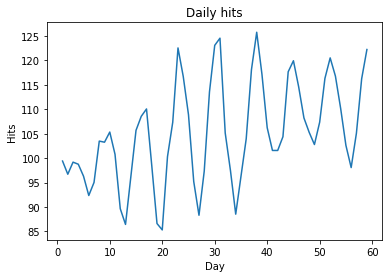

In [6]:
import matplotlib.pyplot as plt

plt.plot(obs[0:60])
plt.title("Daily hits")
plt.xlabel("Day")
plt.ylabel("Hits")

Add random anomalies by increasing the state randomly.

We set the anomaly times manually just for testing, randomise later.

In [7]:
def generate_anomalous_data(structure, 
                            n_obs,
                            m0,
                            C0,
                            V,
                            anomaly_times,
                            ratio):
    ndlm = NormalDLM(structure=structure, V=V)
    state0 = np.random.multivariate_normal(m0, C0)

    states = [state0]

    for t in range(1, n_obs):
        states.append(ndlm.state(states[t-1]))
    
    for t in anomaly_times:
        states[t] = states[t] * ratio
    
    obs = [None]
    for t in range(1, N):
        obs.append(ndlm.observation(states[t]))

    return obs

Generate a new dataset with anomalies at day `27`, `53`, `270` (just for testing).

In [8]:
obs = generate_anomalous_data(structure, 365, m0, C0, 2.5, [27, 53, 270], 3.0)

We will need to use observations as arrays often, so do it now.

In [9]:
Y = np.array(obs[1:]).reshape(-1,1)

Text(0, 0.5, 'Hits')

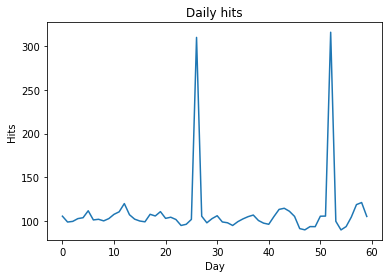

In [10]:
import matplotlib.pyplot as plt

plt.plot(Y[:60])
plt.title("Daily hits")
plt.xlabel("Day")
plt.ylabel("Hits")

Convert into dataframe (just for plotting, really...)

In [11]:
import pandas as pd

In [12]:
df = pd.DataFrame(Y, columns=["y"])
df.head()

,y
0,105.301872
1,98.575037
2,99.327438
3,102.514398
4,103.531128


# (Local) outlier detection

Train the local outlier detector with the whole dataset[^1].

[^1]: Again, just for training purposes.

In [13]:
from sklearn.neighbors import LocalOutlierFactor

clf = LocalOutlierFactor(contamination='auto', novelty=True)
clf.fit(Y)

LocalOutlierFactor(novelty=True)

Store the detected anomalies (if any) on the dataframe.

In [14]:
anomalies = clf.predict(Y)

In [15]:
df['anomaly'] = anomalies

Plot the data for the first 60 days, along with the anomalies (red).

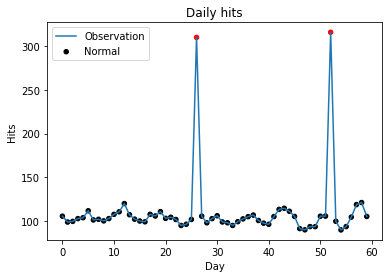

In [23]:
d = df.head(60)
plt.plot(Y[:60])
plt.scatter(x=range(60), y=d['y'], c=list(d['anomaly'].map({1: 'black', -1: 'red'})), s=20)
plt.title("Daily hits")
plt.xlabel("Day")
plt.ylabel("Hits")
plt.legend(['Observation', 'Normal'])

# LSTM forecast

Forecast the data using LSTM.

In [24]:
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Offset the data (history size `1`, i.e. one step behind).

In [25]:
def create_offset(dataset, history=1):
	x, y = [], []
	for i in range(len(dataset)-history-1):
		a = dataset[i:(i+history), 0]
		x.append(a)
		y.append(dataset[i + history, 0])
	return np.array(x), np.array(y)

Normalise data for LSTM.

In [26]:
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(Y)

Split into train and test datasets.

In [27]:
train_size = 250
test_size = N - train_size
train, test = data[0:train_size,:], data[train_size:N,:]

In [28]:
history = 1
trainX, trainY = create_offset(train, history)
testX, testY = create_offset(test, history)

trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

Fit the LSTM.

In [29]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, history)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=125, batch_size=1, verbose=0)

2021-11-22 01:00:30.920610: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Add predictions for plotting.

In [30]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

Un-normalise.

In [31]:
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

Plot the time between 200th and 300th days.

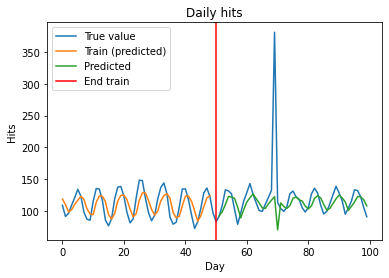

In [39]:
trainPredictPlot = numpy.empty_like(data)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[history:len(trainPredict)+history, :] = trainPredict

testPredictPlot = numpy.empty_like(data)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(history*2)+1:len(data)-1, :] = testPredict

plt.plot(scaler.inverse_transform(data)[200:300])
plt.plot(trainPredictPlot[200:300])
plt.plot(testPredictPlot[200:300])
plt.axvline(x=train_size-200, c="red")
plt.title("Daily hits")
plt.xlabel("Day")
plt.ylabel("Hits")
plt.legend(['True value', 'Train (predicted)', "Predicted", "End train"])
plt.show()

Timepoint `t=268` (non-anomalous in our data)

In [40]:
Y[268]

array([132.46136799])

Should be non-anomalous (`p=1`)

In [41]:
clf.predict(np.array(Y[268]).reshape(-1, 1))

array([1])

Predicted observation:

In [42]:
prediction = model.predict(scaler.transform(np.array(Y[268]).reshape(-1, 1)))
print(f"Observed value = {Y[268][0]}, predicted = {scaler.inverse_transform(prediction)[0][0]}")

Observed value = 132.4613679939697, predicted = 122.3154067993164


Now, timepoint `t=269` (**anomalous** in our data)

In [43]:
Y[269]

array([380.98464193])

Should be **anomalous** (`p=-1`)

In [44]:
clf.predict(np.array(Y[269]).reshape(-1, 1))

array([-1])

Predicted observation:

In [45]:
prediction = model.predict(scaler.transform(np.array(Y[269]).reshape(-1, 1)))
print(f"Observed value = {Y[269][0]}, predicted = {scaler.inverse_transform(prediction)[0][0]}")

Observed value = 380.9846419332487, predicted = 70.0361328125
